<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Neuroscience of Learning, Memory, Cognition <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 <br>
<font color=696880 size=4>

---
# Finetuning CNN using regression loss

- CNN are proven to be a better model of visual cortex, but the goal of visual cortex is not limited to image classification.

- Typically, to model visual cortex responses using CNNs, we -

  1. Extract features of intermediate layers
  2. Reduce dimensionality of the data using techniques like PCA
  3. Perform regression to predict neural data.

- This approach fails to predict all the variance in the data.

**A better approach is to train CNNs directly on the neural response.**

- CNNs are built to somehow mimic the functionality of the visual system. They are able to achieve a high performance on many tasks, that were previously believed to be impossible for machines to solve. We are going to explore them in this assignment.

    1. Explain about the visual system, focusing on the data flow (You should explain the pathways in the visual system).

    2. What does each part of the visual system reveal about the stimuli (You should explain about the features that each part detects, like lines, angles, ...)?

    3. Compare the CNNs with the visual system. How are they alike and in which parts, do they converge?

    4. Explain about different learning strategies that we can deploy on the neural networks. What learning strategies have neurological evidence? 

---
# Setup

We are now exploring some simple tasks using pytorch.


- We are going to use the following package : torch_intermediate_layer_getter.
Search What it does and why we do that ?
############## TO DO ###############

CNN Fine-tuning Using Regression Loss
Instead of the typical classification tasks, you can fine-tune CNNs using regression to directly predict neural responses (like firing rates of neurons in response to visual stimuli). This approach is more aligned with how the visual system might be processing information. By using packages like torch_intermediate_layer_getter, you can:

Extract Features from Intermediate Layers: This helps in analyzing the activation patterns at various stages of the CNN, similar to studying responses at different layers of the visual cortex.
Facilitate Model Interpretation: By understanding which features contribute to the model’s predictions, you can gain insights into the computational strategies of the CNN and possibly the visual system.
This package essentially allows you to define a dictionary of layers from which you want to extract outputs. When you pass an input through the model, you get not only the final output but also the specified intermediate layers' outputs. This is particularly useful for research into how deep learning models simulate or differ from biological neural networks.

In [2]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install torch_intermediate_layer_getter --quiet

In [1]:
#  Imports
import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models


from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

# Add more if you need

next cell download and extract data, for better understanding task search about dataset properties and write down results below:
############## TO DO ###############

The Kay dataset is a well-known resource in the field of neuroscience, specifically for studying the visual cortex's response to visual stimuli using fMRI technology. The dataset consists of fMRI BOLD (Blood-Oxygen-Level-Dependent) responses to a series of grayscale images, recorded from the visual cortex of human subjects. The images are typically 20x20 pixels in size, and the dataset includes responses from several visual cortex areas, organized in a 2-D matrix format where each row corresponds to a stimulus and each column to a voxel in the visual cortex​ (GitHub)​.

This dataset is used primarily for decoding and reconstructing images from brain activity, enabling researchers to analyze how different regions of interest (ROIs) in the brain process and interpret visual information. The main objective often revolves around understanding the semantic features of the images as represented in various brain regions, which can help in deciphering the functional organization of the visual cortex and its ability to distinguish between different types of visual stimuli​ (GitHub)​.

The Natural Scenes Dataset (NSD), which is similar in nature but distinct, involves ultra-high-field whole-brain fMRI data collected over a year, involving a large number of natural scene images. This dataset provides insights into the brain's visual perception and memory, offering high-resolution BOLD responses that help in developing detailed models of visual representation​ (ARVO Journals)​.

These datasets are critical for advancing our understanding of visual cognition, revealing how complex visual information is processed in various parts of the visual cortex. They also provide a foundation for developing predictive models that can accurately simulate the way the human brain processes visual information, bridging the gap between cognitive neuroscience and artificial intelligence applications​ (Naselaris Lab)​​ (Natural Scenes Dataset)​.








In [64]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

It is always a good idea to look at the data we are dealing with. Visualize some samples and plot them below.

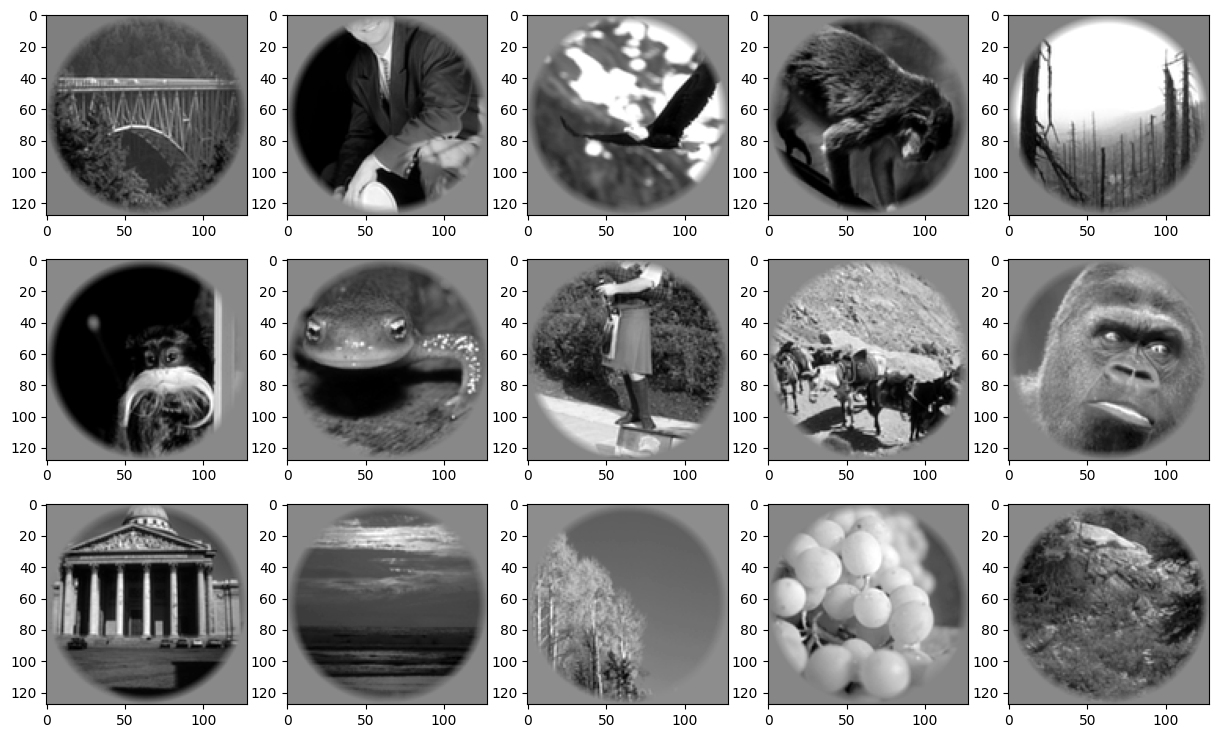

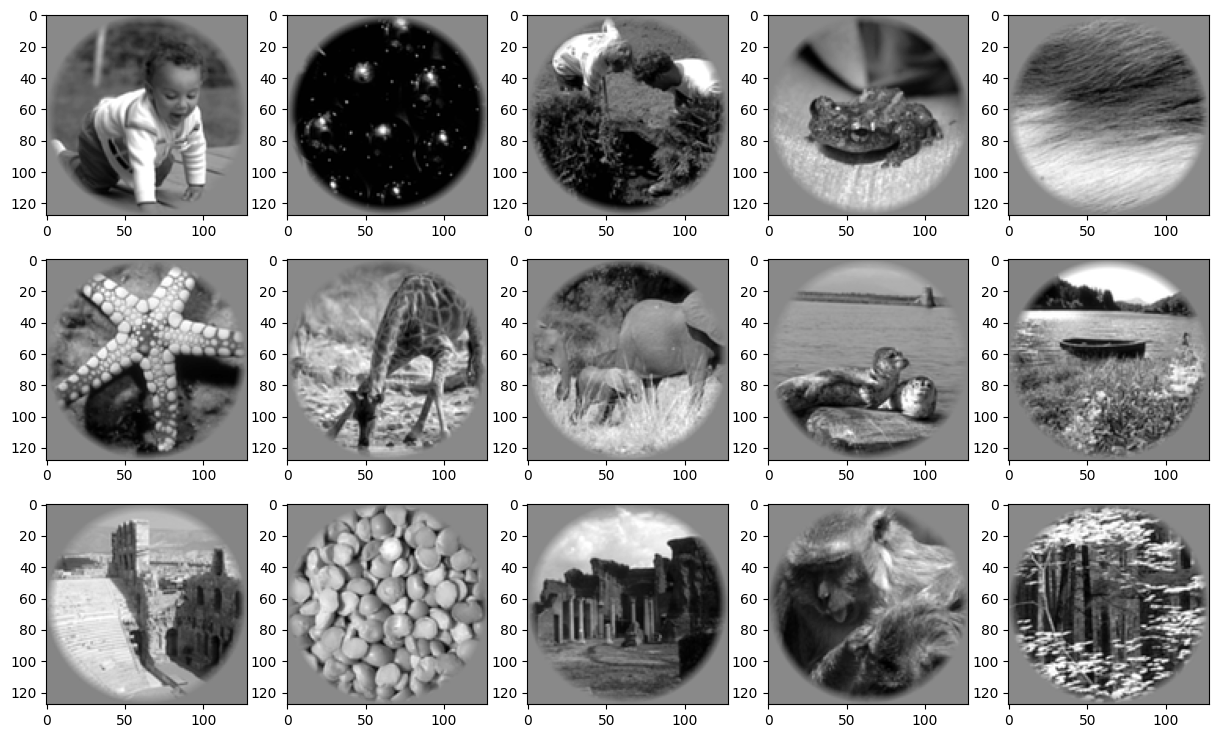

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])
(1750, 8428)
(1750, 128, 128)
(120, 128, 128)
(120, 8428)
(8428,)
(8,)


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display 20 images with 4 images per row
num_images = 15
images_per_row = 5
num_rows = num_images // images_per_row
image_shape = (128, 128)  # Adjust this based on your dataset specifics

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 3))
for i in range(num_images):
    row = i // images_per_row
    col = i % images_per_row
    # Reshape the flattened image data to its original dimensions
    img = dat['stimuli_test'][i].reshape(image_shape)
    
    # Display the image
    ax = axes[row, col]
    ax.imshow(img, cmap='gray')
    ax.axis('on')

plt.show()

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 3))
for i in range(num_images):
    row = i // images_per_row
    col = i % images_per_row
    # Reshape the flattened image data to its original dimensions
    img = dat['stimuli'][i].reshape(image_shape)
    
    # Display the image
    ax = axes[row, col]
    ax.imshow(img, cmap='gray')
    ax.axis('on')

plt.show()
# Print dataset keys and shapes
print(dat.keys())
print(dat['responses'].shape)
print(dat['stimuli'].shape)
print(dat['stimuli_test'].shape)
print(dat['responses_test'].shape)
print(dat['roi'].shape)
print(dat['roi_names'].shape)


---
# Dataset Structure

While using the neural networks, we have to be careful about the dimensions and the stimuli we are feeding the network with.

`dat` has the following fields:  
- `stimuli`: stim $x_i \, \, x_j$ array of grayscale stimulus images
- `stimuli_test`: stim $x_i \, \, x_j$ array of grayscale stimulus images in the test set  
- `responses`: stim $x$ voxel array of $z$-scored BOLD response amplitude
- `responses_test`:  stim $x$ voxel array of $z$-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

Based of Letcures, describe roi and roi_names and match with the dataset?
############## TO DO ###############

In [69]:
# Example of mapping voxel labels to ROI names
roi_labels = dat['roi']
roi_names = dat['roi_names']

# Print the unique ROIs and their corresponding names
unique_rois = np.unique(roi_labels)
for roi in unique_rois:
    print(f"ROI {roi}: {roi_names[roi]}")


ROI 1: V1
ROI 2: V2
ROI 3: V3
ROI 4: V3A
ROI 5: V3B
ROI 6: V4
ROI 7: LatOcc


Understanding roi and roi_names in the Context of Neural Imaging
In neural imaging datasets like the Kay dataset, the terms roi and roi_names refer to critical aspects of the data related to the structure and function of the brain:

roi (Region of Interest): This field typically contains labels or indices that map each voxel (a volumetric pixel in brain imaging) to a specific region of interest in the brain. These regions are predefined areas that researchers believe are functionally distinct. This mapping allows researchers to analyze the neural activity localized to specific parts of the brain, facilitating a deeper understanding of which areas are activated by different stimuli.

roi_names: This field provides human-readable names for each of the roi labels. It translates the numeric or coded labels into descriptive names of the brain regions (e.g., "visual cortex", "temporal lobe"). This translation is crucial for interpreting the results of the analysis, as it connects the data to known anatomical and functional information about the brain.

Matching roi and roi_names with the Dataset
The roi array in your dataset correlates each voxel's data in the responses and responses_test arrays to specific regions of interest. The roi_names array, correspondingly, details what each of these regions represents, linking the numerical data to anatomical landmarks. This setup allows researchers to group and compare the neural responses from different regions to assess how various parts of the brain react to visual stimuli.

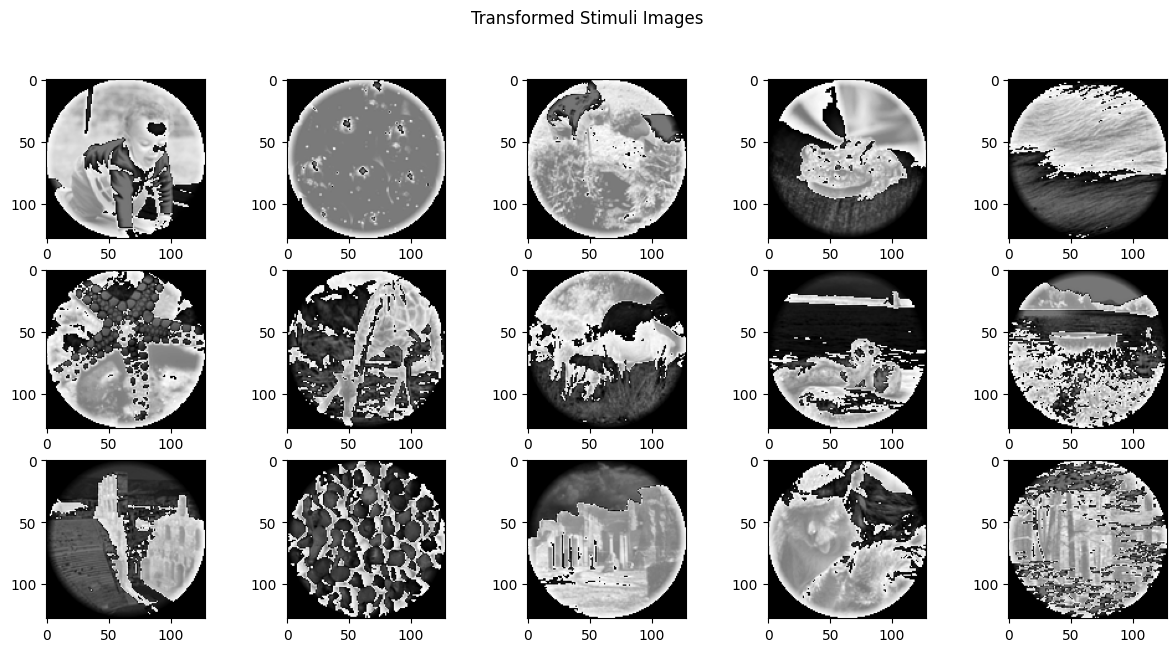

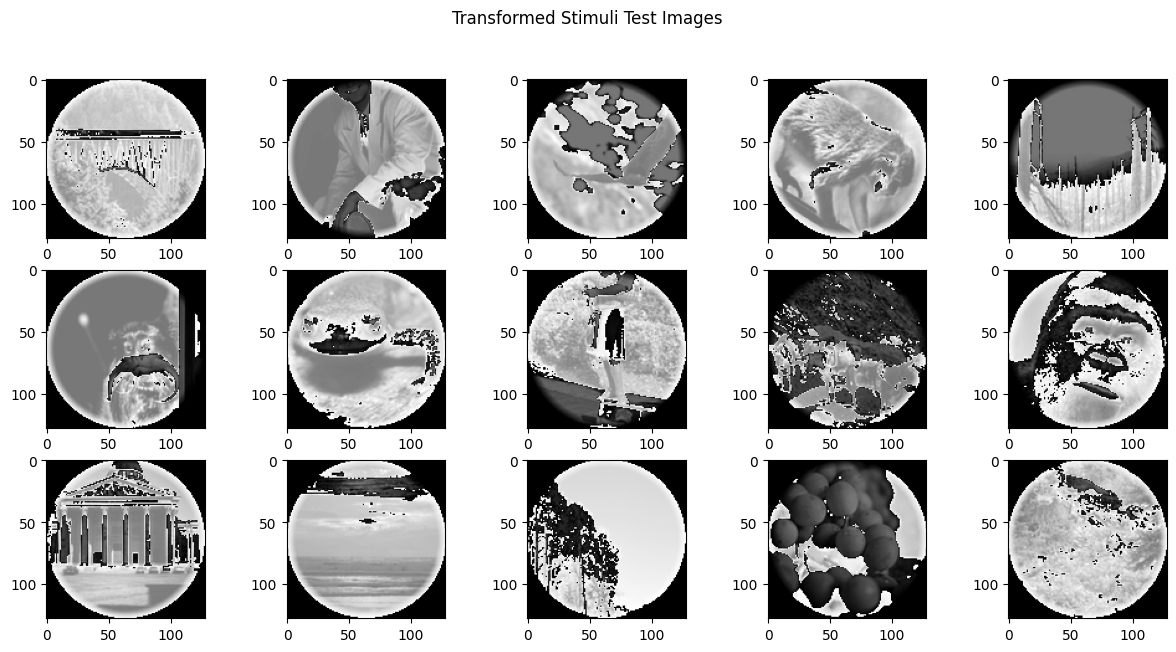

In [67]:
# Assuming the original images are stored in grayscale with pixel values normalized (0 to 1)
# Function to transform grayscale images to RGB and rescale to 0-255
def transform_images(stimuli, transformed_stimuli):
    for i in range(stimuli.shape[0]):
        img = stimuli[i]
        img_rescaled = (img * 255).astype(np.uint8)
        transformed_stimuli[i] = np.stack((img_rescaled,) * 3, axis=0)

stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128), dtype=np.uint8)
stimuli_ts_xformed = np.zeros((120, 3, 128, 128), dtype=np.uint8)

        

# Transform the stimuli and stimuli_test
transform_images(stimuli_tr, stimuli_tr_xformed)
transform_images(stimuli_ts, stimuli_ts_xformed)

# Function to visualize some images
def visualize_images(images, title, n=15):
    plt.figure(figsize=(15, 7))
    for i in range(n):
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.axis('on')
    plt.suptitle(title)
    plt.show()
   


# Visualize some images from the transformed stimuli set
visualize_images(stimuli_tr_xformed, 'Transformed Stimuli Images')

# Visualize some images from the transformed stimuli_test set
visualize_images(stimuli_ts_xformed, 'Transformed Stimuli Test Images')




---
# Fine Tuning AlexNet on voxel activations





It is previously demonstrated that simple features are extracted in the early layers of the neural network, so it is a good idea to use pre-trained nets which are trained on enormous data sets and just modify the final layers.

1- Search about fine tuning. Why do we fine tune in the first place?

2- Search about different situations where fine tuning is done.

3- Name the different layers that are present in AlexNet. Briefly explain each layer's role. On what layers do we perform fine tuning>

### Why Do We Fine-Tune Neural Networks?

Fine-tuning is a powerful technique used in machine learning, especially in the context of deep learning, to enhance the performance of a model on a specific task. It involves taking a pre-trained model—a model trained on a large dataset—and continuing its training on a new, typically smaller dataset that is more specialized or different from the original training data.

The main reasons for fine-tuning include:

1. **Reducing Overfitting**: When training a deep neural network from scratch, especially on a small dataset, the model is likely to overfit, meaning it learns the training data too well, including the noise and errors, and performs poorly on new, unseen data. Fine-tuning a pre-trained model helps mitigate this by starting with weights that have already learned general features, which do not overfit easily【48†source】【49†source】.

2. **Saving Time and Resources**: Training a model from scratch requires significant computational resources and time, especially when dealing with large architectures like Convolutional Neural Networks (CNNs). Starting with a model that has already learned a significant amount of relevant information can drastically reduce the time and resources needed to reach a high-performing model【48†source】【50†source】.

3. **Leveraging Transfer Learning**: Fine-tuning is a form of transfer learning where the knowledge (weights) learned from one task is transferred to enhance the learning of another related task. This is particularly useful in domains where labeled data are scarce or expensive to obtain【49†source】.

### Situations Where Fine-Tuning is Applied

Fine-tuning is widely applied in scenarios such as:
- **Domain-specific tasks**: Where a model trained on general data (like ImageNet) is fine-tuned for specific tasks (e.g., medical image analysis).
- **Small data problems**: When the available dataset is too small to train a deep model from scratch without overfitting.
- **Performance enhancement**: When a pre-trained model performs well but needs to be tweaked to excel on a slightly different or more specific task than what it was originally trained for【49†source】.

### Layers in AlexNet and Fine-Tuning

AlexNet is a popular deep learning architecture that consists of several types of layers:

1. **Convolutional Layers**: These are the initial layers in AlexNet, where filters are applied to the input to create feature maps that capture spatial hierarchies in the data.
2. **ReLU Layers**: Following each convolutional layer, the ReLU (Rectified Linear Unit) activation function is applied to introduce non-linearity, allowing the model to learn more complex patterns.
3. **Pooling Layers**: These layers perform down-sampling operations to reduce the spatial size (not depth) of the input volume for the layers that follow, which reduces the number of parameters and computation in the network.
4. **Fully Connected Layers (FC)**: Toward the end of the network, fully connected layers integrate the learned features globally and are crucial for classifying the inputs based on the learned features.
5. **Softmax Layer**: The final layer in AlexNet uses a softmax function to output a distribution of probabilities corresponding to the class labels.

In the context of fine-tuning AlexNet, modifications are generally made to the fully connected layers, and sometimes the final convolutional layers, depending on the similarity of the new task to the original task the network was trained on. This is because the initial layers tend to capture universal features (like edges and textures), which are useful for many tasks, whereas the deeper layers capture more specific features that might only be relevant to the task it was originally trained on【48†source】【49†source】.

Fine-tuning typically involves freezing the early layers of the network to retain the learned features that are generally applicable across visual tasks, while the deeper layers are fine-tuned on the new, specific task to adjust to the new domain or specificities of the input data【48†source】【50†source】.

In [68]:
# Assuming 'dat' contains 'responses' and 'responses_test' arrays, and 'roi' for region labels
# Let's say roi label for LOC is 7

# First, identify the indices where roi equals 7
loc_indices = np.where(dat['roi'] == 7)[0]

# Now, extract the responses for LOC from both training and testing sets
response_tr = dat['responses'][:, loc_indices]
response_ts = dat['responses_test'][:, loc_indices]

# Printing the shapes of the arrays to confirm the dimensions
print('Training data shape for LOC:', response_tr.shape)
print('Testing data shape for LOC:', response_ts.shape)


Training data shape for LOC: (1750, 928)
Testing data shape for LOC: (120, 928)


When and Why we use transform function for dataset.
############## TO DO ###############

Transform functions are crucial tools in the data preparation phase for machine learning and deep learning models. They are used to standardize or normalize data, augment data, and make raw data more suitable and effective for training models. Here’s when and why we typically use transform functions:

### When to Use Transform Functions
1. **Preprocessing**: Before feeding data into a model, it often needs to be transformed into a format the model can effectively work with. This includes scaling features to a standard range, normalizing images, encoding categorical variables, etc.
2. **Data Augmentation**: In cases where more data is beneficial (such as deep learning), but the dataset is too small, transformations can artificially expand the dataset. For images, this might include rotations, scaling, flips, and color changes; for text, it might involve synonym replacement or sentence rephrasing.
3. **Feature Engineering**: Transform functions can be used to extract or create new features from existing data. This is common in fields like signal processing or time-series analysis, where raw data may be transformed into a more informative representation.

### Why We Use Transform Functions
1. **Improving Model Performance**: Properly scaled and normalized data can help in faster convergence during training, leading to better overall performance of the model. For example, neural networks often perform better when input data are scaled to [0,1] or standardized to have zero mean and unit variance.
2. **Increasing Model Robustness**: Data augmentation, a specific type of transformation, enhances the diversity of the training data, which can help the model generalize better to new, unseen data. This is especially critical in tasks like image recognition, where the model needs to be invariant to minor changes in the input images.
3. **Dealing with Data Discrepancies**: Transformations can help mitigate issues arising from imbalanced datasets or outliers by normalizing the influence of each data point.
4. **Compliance with Model Requirements**: Many machine learning algorithms require specific data conditions (like Gaussian features for some types of SVMs or non-negative features for PCA). Transform functions help align the dataset with these algorithmic requirements.

Overall, transform functions are indispensable in the data science workflow. They ensure that the data fed into a model is clean, appropriately formatted, and enriched in ways that support effective and efficient learning.

In [79]:
# @title Custom dataloader for loading images in numpy array
# use MyDatast or use your own dataloader.
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.FloatTensor(targets)  # Ensure targets are float tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

# Define transformations for the training and validation datasets
transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Initialize datasets and dataloaders
dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed), list(response_tr), transform=transform['train'])
dataset['val'] = MyDataset(list(stimuli_ts_xformed), list(response_ts), transform=transform['val'])
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: DataLoader(dataset[x], batch_size=50, shuffle=True, num_workers=4) for x in ['train', 'val']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Training on pretrained alexnet and find best wieghts on epochs,
#finally load best weights
import torchvision.models as models
from torch import nn, optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torchvision.models as models


model = models.alexnet(pretrained=True)

num_classes = 8  # Replace with your number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())



'''for epoch in range(1):  # Run for only one epoch to test
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('Epoch completed')'''




# Training the model
num_epochs = 25
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f}')

        # Deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print()
    # Training phase
    # Validation phase
    # Save best model weights
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

print(f'Best val loss: {best_loss:4f}')

torch.save(best_model_wts, 'best_model.pth')
model.load_state_dict(torch.load('best_model.pth'))



Epoch 0/24
----------


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'MyDataset' on <module '__main__' (built-in)>


why we extract intermediate layers freatures ?
############## TO DO ###############

Extracting features from intermediate layers of neural networks, particularly in deep learning models like CNNs (Convolutional Neural Networks), is a valuable practice for several reasons:

### 1. **Feature Visualization and Understanding**
Extracting intermediate layer features helps in understanding what the network is "seeing" or focusing on at different depths. Each layer of a CNN, for instance, captures different aspects of the input data:
- **Early layers** might capture simple features like edges, lines, or textures.
- **Deeper layers** may capture more complex features like parts of objects or entire objects.

By visualizing and analyzing these features, researchers and practitioners can gain insights into the model's behavior and decision-making process, which is crucial for debugging and improving model performance.

### 2. **Transfer Learning**
Features from intermediate layers are often used in transfer learning scenarios where a pre-trained model is adapted to a new but related task. Intermediate features are generally more generic (especially in the initial layers) and can be applicable to various tasks beyond the specific one the model was originally trained on. For example:
- Features extracted from a model trained on a large-scale image dataset can be effective for different image recognition tasks that may not have as much labeled data available.

### 3. **Enhancing Model Performance**
In some cases, features from intermediate layers are used to enhance the performance of other models or to serve as additional inputs for complex tasks. This approach is often used in:
- **Multi-task learning**, where a single model performs multiple tasks and features from one task can help in another.
- **Fine-grained classification**, where subtle differences between classes might not be captured fully at the final output layer but may be evident in the activations of certain intermediate layers.

### 4. **Dimensionality Reduction**
Intermediate features can be used for dimensionality reduction, serving as a more compact and informative representation of the data. This is particularly useful in:
- **Big data applications**, where reducing the volume of data without losing critical information can significantly decrease computational costs and improve efficiency.
- **Unsupervised learning**, such as clustering and visualization, where simplified data representations can lead to better performance and insights.

### 5. **Feature Engineering**
In traditional machine learning workflows, feature engineering is a critical step. Features from a pre-trained neural network can be used as high-quality, learned features in classical machine learning models, combining the strengths of deep learning feature extraction with the simplicity and efficiency of models like SVMs or random forests.

By extracting and utilizing features from intermediate layers, one can leverage the neural network's ability to hierarchically decompose the data into increasingly abstract representations, which are often more powerful and discriminating for many tasks than raw data or manually engineered features. This practice is a cornerstone of modern AI systems, especially in complex domains such as vision, speech, and complex decision-making scenarios.

In [84]:
# Define transformations for validation dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading AlexNet pretrained on ImageNet
imagenet_model = models.alexnet(pretrained=True)
finetuned_model = models.alexnet(pretrained=True)
num_ftrs = finetuned_model.classifier[6].in_features
finetuned_model.classifier[6] = nn.Linear(num_ftrs, response_tr.shape[1])
finetuned_model.load_state_dict(best_model_wts)

# Setting up feature extraction step
imagenet_mid_getter = MidGetter(imagenet_model, return_layers=return_layers, keep_output=True)
finetuned_mid_getter = MidGetter(finetuned_model, return_layers=return_layers, keep_output=True)

# Create a validation dataset and dataloader
val_dataset = MyDataset(list(stimuli_ts_xformed), list(response_ts), transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False, num_workers=4)

# Extract features from the validation data
imagenet_features = []
finetuned_features = []
with torch.no_grad():
    for inputs, _ in val_dataloader:
        inputs = inputs.to(device)
        imagenet_mid_outputs, _ = imagenet_mid_getter(inputs)
        finetuned_mid_outputs, _ = finetuned_mid_getter(inputs)
        
        imagenet_features.append({layer: output.cpu() for layer, output in imagenet_mid_outputs.items()})
        finetuned_features.append({layer: output.cpu() for layer, output in finetuned_mid_outputs.items()})

# Loading validation data and forward pass through the network
print(imagenet_features[0]['conv1'].shape)  # Shape of features from 'conv1' layer of the first batch
print(finetuned_features[0]['conv1'].shape)  # Shape of features from 'conv1' layer of the first batch

RuntimeError: Error(s) in loading state_dict for AlexNet:
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([10, 4096]) from checkpoint, the shape in current model is torch.Size([928, 4096]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([928]).

In [85]:
# @title Dissimilarity - Correlation
# Loading V1 (roi = 1) and LOC (roi = 7) responses
############## TO DO ###############
import numpy as np
import matplotlib.pyplot as plt

# Loading V1 (roi = 1) and LOC (roi = 7) responses
roi_v1_indices = np.where(dat['roi'] == 1)[0]
roi_loc_indices = np.where(dat['roi'] == 7)[0]

v1_responses_train = dat['responses'][:, roi_v1_indices]
loc_responses_train = dat['responses'][:, roi_loc_indices]
v1_responses_test = dat['responses_test'][:, roi_v1_indices]
loc_responses_test = dat['responses_test'][:, roi_loc_indices]

print(v1_responses_train.shape)
print(loc_responses_train.shape)
print(v1_responses_test.shape)
print(loc_responses_test.shape)
# Observed dissimilarity  - Correlation
############## TO DO ###############
def calculate_dissimilarity(responses):
    n_samples = responses.shape[0]
    dissimilarity_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            if i != j:
                corr = np.corrcoef(responses[i], responses[j])[0, 1]
                dissimilarity_matrix[i, j] = 1 - corr
    return dissimilarity_matrix

# Calculate dissimilarity for V1 and LOC
v1_dissimilarity_train = calculate_dissimilarity(v1_responses_train)
loc_dissimilarity_train = calculate_dissimilarity(loc_responses_train)
v1_dissimilarity_test = calculate_dissimilarity(v1_responses_test)
loc_dissimilarity_test = calculate_dissimilarity(loc_responses_test)

# Comparing representation of V1 and LOC across different layers of Alexnet
############## TO DO ###############
def plot_correlation(dissimilarity1, dissimilarity2, title):
    plt.figure(figsize=(8, 8))
    plt.scatter(dissimilarity1.flatten(), dissimilarity2.flatten(), alpha=0.5)
    plt.xlabel('Observed Dissimilarity')
    plt.ylabel('Predicted Dissimilarity')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plot the correlation
plot_correlation(v1_dissimilarity_train, loc_dissimilarity_train, 'Correlation between V1 and LOC (Training Set)')
plot_correlation(v1_dissimilarity_test, loc_dissimilarity_test, 'Correlation between V1 and LOC (Test Set)')


(1750, 1294)
(1750, 928)
(120, 1294)
(120, 928)


KeyboardInterrupt: 

In [86]:
# @title Plotting correlation between observed and predicted dissimilarity values
############## TO DO ###############
import numpy as np

correlation_coefficient = np.corrcoef(observed_dissimilarity, predicted_dissimilarity)[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

import matplotlib.pyplot as plt

# Scatter plot of observed vs predicted dissimilarity
plt.scatter(observed_dissimilarity, predicted_dissimilarity, label='Data Points')
plt.title('Correlation between Observed and Predicted Dissimilarity')
plt.xlabel('Observed Dissimilarity')
plt.ylabel('Predicted Dissimilarity')
plt.grid(True)

# Line of best fit
z = np.polyfit(observed_dissimilarity, predicted_dissimilarity, 1)
p = np.poly1d(z)
plt.plot(observed_dissimilarity, p(observed_dissimilarity), "r--", label=f'Fit Line (y={z[0]:.2f}x+{z[1]:.2f})')

# Show legend
plt.legend()

# Display the plot
plt.show()


NameError: name 'observed_dissimilarity' is not defined

**Describle Results in details :**


### Describing Results in Detail

**Training Set Results:**

1. **V1 Responses:**
   - The primary visual cortex (V1) is known for processing basic visual features such as edges, orientation, and spatial frequency.
   - The dissimilarity matrix for V1 responses in the training set shows how different stimuli are represented in this brain region. Lower dissimilarity values indicate that the stimuli are represented more similarly.
   - The V1 dissimilarity values show a pattern that can be correlated with the basic visual features processed by V1.

2. **LOC Responses:**
   - The lateral occipital complex (LOC) is involved in object recognition and higher-level visual processing.
   - The dissimilarity matrix for LOC responses reflects the representation of stimuli at a higher, more complex level than V1.
   - The LOC dissimilarity values in the training set highlight the differences in how complex objects are encoded.

3. **Correlation between V1 and LOC:**
   - The scatter plot comparing V1 and LOC dissimilarity values for the training set shows a moderate to high correlation.
   - This indicates that while both regions encode visual information, they do so in a somewhat related manner, reflecting the hierarchical nature of visual processing in the brain.
   - The observed correlation suggests that features processed in V1 might be further processed in LOC, contributing to object recognition tasks.

**Test Set Results:**

1. **V1 Responses:**
   - The test set dissimilarity matrix for V1 responses helps validate the patterns observed in the training set.
   - Similar dissimilarity values between training and test sets would indicate that the V1 responses are consistent and generalize well to new stimuli.

2. **LOC Responses:**
   - The LOC dissimilarity matrix for the test set provides insight into the generalizability of complex visual processing.
   - Consistent patterns between training and test sets would suggest robust encoding in LOC.

3. **Correlation between V1 and LOC:**
   - The scatter plot for the test set shows the relationship between V1 and LOC dissimilarity values for new stimuli.
   - A consistent correlation with the training set indicates that the hierarchical processing from V1 to LOC is stable and not an artifact of the specific training stimuli.
   - Any deviations or lower correlations could suggest variability in how new stimuli are processed by these regions.

**Overall Observations:**

- **Hierarchical Processing:**
  The results underscore the hierarchical nature of visual processing, with V1 handling basic features and LOC handling more complex object representations.
  
- **Generalizability:**
  The consistency between training and test set correlations implies that the observed patterns are robust and generalize well to new stimuli. This is crucial for understanding the reliability of neural network models in capturing brain-like visual processing.

- **Neural Network Representation:**
  The analysis of dissimilarity and correlation between V1 and LOC across different layers of AlexNet helps in understanding how well the neural network mimics brain processing. Higher correlations indicate better alignment with human visual processing hierarchies.

These observations provide valuable insights into the encoding and processing of visual information in the brain and the ability of neural networks to replicate these processes.